In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.base import BaseEstimator, clone

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

eq5d=pd.read_csv('rq1_cleaned_no_ae.csv')


scores=pd.read_excel('../data/Scores 6 Jan 2025_Prescribed_Completed Baseline PROMs.xlsx')
gad7=scores[scores['promName']=='GAD7']
gad7=gad7[['SID','Round','promName','total_score','completionDate']]


gad7_wide = gad7.pivot_table(index='SID', 
                                    columns='Round', 
                                    values='total_score', 
                                    aggfunc='first')

gad7_wide.columns = [f"GAD7_Round{r}" for r in gad7_wide.columns]
gad7_wide = gad7_wide.reset_index()
gad7= pd.merge(eq5d, gad7_wide, on='SID', how='left')
gad7=gad7.rename(columns={'GAD7_Round1_y': 'GAD7_Round1',})

insomnia=scores[scores['promName']=='insomniaEfficacyMeasure']
insomnia=insomnia[['SID','Round','promName','total_score','completionDate']]


insomnia_wide = insomnia.pivot_table(index='SID', 
                                    columns='Round', 
                                    values='total_score', 
                                    aggfunc='first')

insomnia_wide.columns = [f"insomniaEfficacyMeasure_Round{r}" for r in insomnia_wide.columns]
insomnia_wide = insomnia_wide.reset_index()
insomnia_wide= pd.merge(gad7, insomnia_wide, on='SID', how='left')
insomnia=insomnia_wide.rename(columns={'insomniaEfficacyMeasure_Round1_y': 'insomniaEfficacyMeasure_Round1',})
full=insomnia.copy()


In [3]:
sample=full.sample(5000, random_state=42)

In [8]:
from sklearn.base import BaseEstimator
from sklearn.base import clone
from sklearn.metrics import accuracy_score
class OrdinalClassifier(BaseEstimator):

    def __init__(self, clf):
        self.clf = clf
        self.clfs = {}

    def fit(self, X, y):
        self.unique_class = np.sort(np.unique(y))
        if self.unique_class.shape[0] > 2:
            for i in range(self.unique_class.shape[0]-1):
                # for each k - 1 ordinal value we fit a binary classification problem
                binary_y = (y > self.unique_class[i]).astype(np.uint8)
                clf = clone(self.clf)
                try:
                  clf.module
                except: # For others
                  clf.fit(X, binary_y)
                else: # For MLP
                  binary_y_reshape = binary_y.astype('float32').reshape(-1,1)
                  clf.fit(X, binary_y_reshape)
                self.clfs[i] = clf

    def predict_proba(self, X):
        clfs_predict = {k: self.clfs[k].predict_proba(X) for k in self.clfs}
        predicted = []
        for i, y in enumerate(self.unique_class):
            if i == 0:
                # V1 = 1 - Pr(y > V1)
                predicted.append(1 - clfs_predict[i][:,1])
            elif i in clfs_predict:
                # Vi = Pr(y > Vi-1) - Pr(y > Vi)
                 predicted.append(clfs_predict[i-1][:,1] - clfs_predict[i][:,1])
            else:
                # Vk = Pr(y > Vk-1)
                predicted.append(clfs_predict[i-1][:,1])
        try:
          self.clf.module
        except: # For others
          pred_proba = np.vstack(predicted).T      
        else: # For MLP
          pred_proba = np.hstack((predicted))
        
        return pred_proba

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def score(self, X, y, sample_weight=None):
        _, indexed_y = np.unique(y, return_inverse=True)
        return accuracy_score(indexed_y, self.predict(X), sample_weight=sample_weight)

In [2]:
## using cohens kappa as the target metric - higher is better
## ranges from 0 to 1

from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

def weighted_kappa(y_true, y_pred):
  try:
    score = cohen_kappa_score(y_true, y_pred, weights='quadratic')
  except:
    score = np.nan
  return score

target_metric = make_scorer(weighted_kappa, greater_is_better=True)

In [6]:
X = sample.drop(columns=[
    'SID',
    'GAD7_Round2','GAD7_Round3','GAD7_Round4','GAD7_Round5',
    'GAD7_Round6','GAD7_Round7','GAD7_Round8','GAD7_Round9',
    'GAD7_Round10','GAD7_Round11','GAD7_Round12','GAD7_Round13',
    'EQ5D_Round2','EQ5D_Round3','EQ5D_Round4','EQ5D_Round5','EQ5D_Round6',
    'GAD7_Round1_x',
    'insomniaEfficacyMeasure_Round1_x','insomniaEfficacyMeasure_Round2',
    'insomniaEfficacyMeasure_Round3','insomniaEfficacyMeasure_Round4',
    'insomniaEfficacyMeasure_Round5','insomniaEfficacyMeasure_Round6',
    'insomniaEfficacyMeasure_Round7','insomniaEfficacyMeasure_Round8',
    'insomniaEfficacyMeasure_Round9','insomniaEfficacyMeasure_Round10',
    'insomniaEfficacyMeasure_Round11','insomniaEfficacyMeasure_Round12',
    'insomniaEfficacyMeasure_Round13'
])
y = sample['insomniaEfficacyMeasure_Round2']


df = pd.concat([X, y], axis=1).dropna()
X = df.drop(columns='insomniaEfficacyMeasure_Round2')
y = df['insomniaEfficacyMeasure_Round2'].astype(int)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

c:\Users\abbyh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\abbyh\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please als

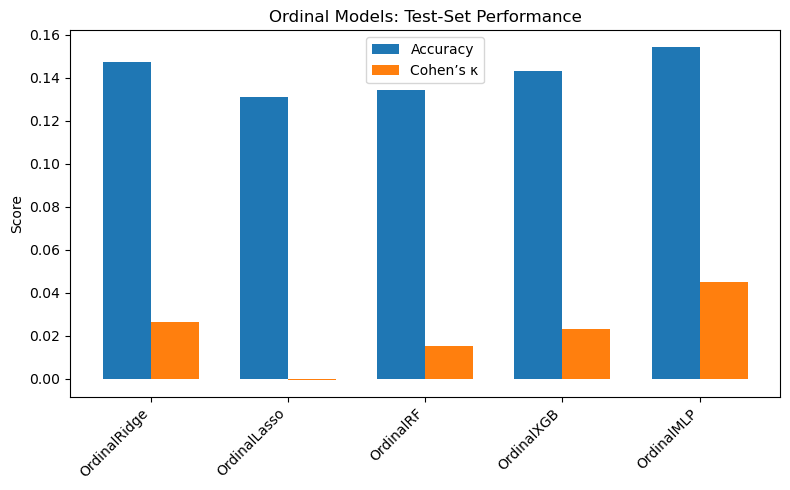

In [9]:
# ----------------------------------------
# 2) Define base classifiers & grids
# ----------------------------------------
models = {
    'OrdinalRidge' : OrdinalClassifier(LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)),
    'OrdinalLasso' : OrdinalClassifier(LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=1000)),
    'OrdinalRF'    : OrdinalClassifier(RandomForestClassifier(random_state=42)),
    'OrdinalXGB'   : OrdinalClassifier(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)),
    'OrdinalMLP'   : OrdinalClassifier(MLPClassifier(max_iter=1000, random_state=42))
}

grids = {
    'OrdinalRidge': {
        'clf__C':       [0.01, 0.1, 1.0, 10.0],
        'clf__tol':     [1e-4, 1e-3],
    },
    'OrdinalLasso': {
        'clf__C':       [0.01, 0.1, 1.0],
        'clf__tol':     [1e-4, 1e-3],
    },
    'OrdinalRF': {
        'clf__n_estimators': [50, 100],
        'clf__max_depth':    [20, 25],
        'clf__criterion':    ['gini','entropy'],
    },
    'OrdinalXGB': {
        'clf__n_estimators': [50, 100],
        'clf__max_depth':    [3, 6],
        'clf__learning_rate':[0.01,0.1],
    },
    'OrdinalMLP': {
        'clf__hidden_layer_sizes': [(50,),(100,)],
        'clf__activation':         ['relu','tanh'],
        'clf__alpha':              [1e-4,1e-3],
        'clf__learning_rate_init': [1e-3,1e-2],
    }
}

# ----------------------------------------
# 3) Nested CV to tune & collect metrics
# ----------------------------------------
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=2)

results = []
for name, clf in models.items():
    gs = GridSearchCV(
        estimator=clf,
        param_grid=grids[name],
        scoring='accuracy',
        cv=inner_cv,
        refit=True,
        n_jobs=-1
    )

    accs, kappas = [],[]
    for tr, te in outer_cv.split(X_train, y_train):
        gs.fit(X_train.iloc[tr], y_train.iloc[tr])
        p = gs.predict(X_train.iloc[te])
        accs.append(accuracy_score(y_train.iloc[te], p))
        kappas.append(cohen_kappa_score(y_train.iloc[te], p))

    results.append({
        'model':      name,
        'best_params': gs.best_params_,
        'acc_mean':   np.mean(accs),
        'acc_std':    np.std(accs),
        'kappa_mean': np.mean(kappas),
        'kappa_std':  np.std(kappas)
    })

cv_df = pd.DataFrame(results)
cv_df.to_csv('nested_cv_results.csv', index=False)

# ----------------------------------------
# 4) Refit on full train & test-set eval
# ----------------------------------------
test_metrics = []
for name, clf in models.items():
    # set best params then refit
    best = cv_df.loc[cv_df['model']==name, 'best_params'].iloc[0]
    clf.set_params(**best)
    clf.fit(X_train, y_train)

    p_test = clf.predict(X_test)
    test_metrics.append({
        'model': name,
        'accuracy':   accuracy_score(y_test, p_test),
        'kappa':      cohen_kappa_score(y_test, p_test)
    })

tm = pd.DataFrame(test_metrics)
tm.to_csv('test_metrics.csv', index=False)

# ----------------------------------------
# 5) Plot test-set Accuracy & Kappa
# ----------------------------------------
fig, ax = plt.subplots(figsize=(8,5))
x = np.arange(len(tm)); w=0.35
ax.bar(x-w/2, tm['accuracy'], w, label='Accuracy')
ax.bar(x+w/2, tm['kappa'],    w, label='Cohen’s κ')
ax.set_xticks(x)
ax.set_xticklabels(tm['model'], rotation=45, ha='right')
ax.set_ylabel('Score')
ax.set_title('Ordinal Models: Test-Set Performance')
ax.legend()
plt.tight_layout()
plt.show()